# Import the drive since the dataset is stored in the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Install and import the relevant packages

In [ ]:
!pip install nibabel -q
!pip install tqdm -q
!pip install segmentation-models-pytorch-3d -q
!pip install torchinfo -q
!pip install livelossplot -q
!pip install torchmetrics -q
!pip install tensorboard -q

In [ ]:
# =============================================================================
# 1) Imports & Device
# =============================================================================
import os
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Build the Dataset class

In [ ]:
# =============================================================================
# 2) Dataset Class (resizes all volumes to 128³) – corrected interpolation
# =============================================================================
class BraTSDataset128(Dataset):
    def __init__(self, root_dir):
        self.subject_dirs = sorted([
            os.path.join(root_dir, d)
            for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
    def __len__(self):
        return len(self.subject_dirs)
    def __getitem__(self, idx):
        sub = self.subject_dirs[idx]
        files = os.listdir(sub)
        # Load segmentation mask
        seg = nib.load(os.path.join(sub, next(f for f in files if f.endswith("seg.nii.gz"))))\
                 .get_fdata().astype(np.int64)
        # Load & normalize modalities
        mods = []
        for tag in ("t1c","t1n","t2f","t2w"):
            arr = nib.load(os.path.join(sub, next(f for f in files if f.endswith(f"-{tag}.nii.gz"))))\
                     .get_fdata().astype(np.float32)
            arr = (arr - arr.mean()) / (arr.std() or 1.0)
            mods.append(arr)
        image = np.stack(mods, axis=0)  # (4, H, W, D)
        # Convert to torch and add batch dim for resize
        img_t = torch.from_numpy(image).unsqueeze(0)      # (1,4,H,W,D)
        lbl_t = torch.from_numpy(seg)[None,None]          # (1,1,H,W,D)
        # Resize to 128×128×128 (only spatial dims)
        img_t = F.interpolate(img_t, size=(128, 128, 128), mode='trilinear', align_corners=False)
        lbl_t = F.interpolate(lbl_t.float(), size=(128, 128, 128), mode='nearest').long()
        img_t = img_t.squeeze(0)            # (4,128,128,128)
        lbl_t = lbl_t.squeeze(0).squeeze(0)  # (128,128,128)
        return {"image": img_t, "label": lbl_t}

Original shape: (4, 182, 218, 182)
Resized tensor shape: torch.Size([1, 4, 128, 128, 128])


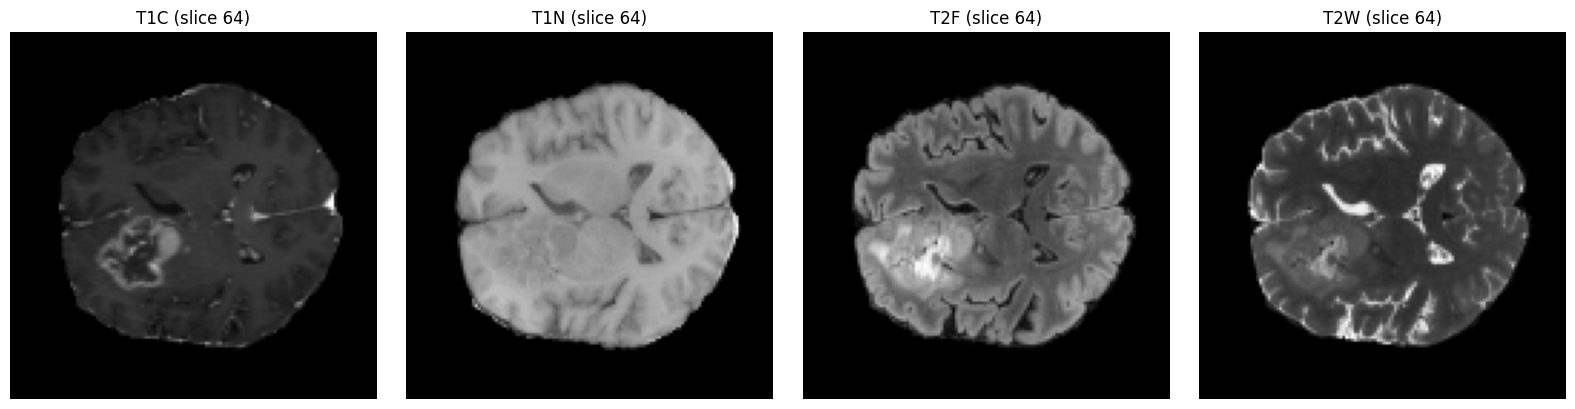

In [ ]:
# Cell: Load a sample, resize to 128³, print shape & visualize modalities

import os
import nibabel as nib
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

# 1) Path to a single subject folder
subject_folder = '/content/drive/MyDrive/BraTS2025-GLI-PRE-Challenge-TrainingData/BraTS-GLI-00000-000'

# 2) Load and stack the 4 modalities
modality_tags = ['t1c', 't1n', 't2f', 't2w']
mods = []
for tag in modality_tags:
    fn = next(f for f in os.listdir(subject_folder) if f.endswith(f'-{tag}.nii.gz'))
    arr = nib.load(os.path.join(subject_folder, fn)).get_fdata().astype(np.float32)
    # z-score normalize
    arr = (arr - arr.mean()) / (arr.std() or 1.0)
    mods.append(arr)
image_np = np.stack(mods, axis=0)  # shape: (4, H, W, D)
print("Original shape:", image_np.shape)

# 3) Convert to tensor and resize to (1,4,128,128,128)
img_t = torch.from_numpy(image_np).unsqueeze(0)  # (1,4,H,W,D)
img_resized = interpolate(img_t, size=(128,128,128), mode='trilinear', align_corners=False)
print("Resized tensor shape:", img_resized.shape)

# 4) Visualize the middle slice of each modality
slice_idx = img_resized.shape[-1] // 2
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, tag in enumerate(modality_tags):
    axes[i].imshow(img_resized[0, i, :, :, slice_idx].cpu().numpy(), cmap='gray')
    axes[i].set_title(f"{tag.upper()} (slice {slice_idx})")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Get the dataset splits and dataloaders

In [ ]:
# =============================================================================
# 3) Data Loading & Splits
# =============================================================================
# Set the dataset path (modify to your location)
dataset_path = '/content/drive/MyDrive/BraTS2025-GLI-PRE-Challenge-TrainingData'

# Create the full dataset (full-volume each sample)
full_dataset = BraTSDataset128(dataset_path)

# Choose a subset percentage (e.g., using 20% of the data)
subset_percent = 0.35
subset_length = int(len(full_dataset) * subset_percent)
print(f"Using subset of {subset_length} samples out of {len(full_dataset)} total subjects.")

# Create a subset
subset_indices = list(range(subset_length))
subset_dataset = Subset(full_dataset, subset_indices)

# Now split the subset into train/validation/test splits (80/10/10 split)
total_samples = len(subset_dataset)
train_len = int(0.6 * total_samples)
val_len   = int(0.2 * total_samples)
test_len  = total_samples - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_len, val_len, test_len])
print(f"Train/Val/Test split (subset): {train_len} / {val_len} / {test_len} samples.")

# Create DataLoaders with a small batch size (adjust num_workers if needed)
batch_size = 1  # You can increase if memory permits
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Using subset of 437 samples out of 1251 total subjects.
Train/Val/Test split (subset): 262 / 87 / 88 samples.


# Define helper functions and loss functions

In [ ]:
# =============================================================================
# 4) Loss & Metric Functions
# =============================================================================
def center_crop_target(label, target_shape):
    *batch, H,W,D = label.shape
    tH,tW,tD = target_shape
    sh,sw,sd = (H-tH)//2, (W-tW)//2, (D-tD)//2
    slices = [slice(None)]*len(batch) + [slice(sh,sh+tH), slice(sw,sw+tW), slice(sd,sd+tD)]
    return label[tuple(slices)]

def dice_loss(pred, target, smooth=1e-5):
    P = torch.softmax(pred, dim=1)
    T = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])\
                    .permute(0,4,1,2,3).float()
    inter = (P*T).sum(dim=(2,3,4))
    union = P.sum((2,3,4)) + T.sum((2,3,4))
    dice = (2*inter + smooth)/(union+smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    if pred.shape[2:] != target.shape[1:]:
        target = center_crop_target(target.unsqueeze(1), pred.shape[2:]).squeeze(1)
    ce = nn.CrossEntropyLoss()(pred, target)
    dl = dice_loss(pred, target)
    return ce + dl

def compute_metrics_single(pred, label, num_classes=4):
    ious = []
    for cls in range(num_classes):
        p = (pred==cls)
        g = (label==cls)
        inter = (p&g).sum().item()
        union = (p|g).sum().item()
        if union>0: ious.append(inter/union)
    mean_iou = np.nan if not ious else np.mean(ious)
    acc = (pred==label).sum().item() / label.numel()
    return mean_iou, acc


# Build the model class (architecture)

In [ ]:
# =============================================================================
# 5) Model: Inception + Attention U-Net
# =============================================================================
class GridAttentionBlock(nn.Module):
    def __init__(self, in_ch, gate_ch, inter_ch):
        super().__init__()
        self.theta = nn.Conv3d(in_ch,   inter_ch, kernel_size=2, stride=2, bias=False)
        self.phi   = nn.Conv3d(gate_ch, inter_ch, kernel_size=1, bias=True)
        self.psi   = nn.Conv3d(inter_ch,    1,   kernel_size=1, bias=True)
        self.W     = nn.Sequential(
            nn.Conv3d(in_ch, in_ch, kernel_size=1, bias=False),
            nn.BatchNorm3d(in_ch)
        )
    def forward(self, x, g):
        theta_x = self.theta(x)
        phi_g   = F.interpolate(self.phi(g), size=theta_x.shape[2:], mode='trilinear', align_corners=False)
        f       = F.relu(theta_x + phi_g, inplace=True)
        psi_f   = torch.sigmoid(self.psi(f))
        psi_up  = F.interpolate(psi_f, size=x.shape[2:], mode='trilinear', align_corners=False)
        y       = psi_up.expand_as(x) * x
        return self.W(y)

class InceptionBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        b = out_ch // 4
        self.br1 = nn.Conv3d(in_ch, b, kernel_size=1, padding=0)
        self.br2 = nn.Conv3d(in_ch, b, kernel_size=3, padding=1)
        self.br3 = nn.Conv3d(in_ch, b, kernel_size=5, padding=2)
        self.br4 = nn.Conv3d(in_ch, b, kernel_size=7, padding=3)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        y1 = self.br1(x); y2 = self.br2(x)
        y3 = self.br3(x); y4 = self.br4(x)
        return self.relu(torch.cat([y1,y2,y3,y4], dim=1))

def center_crop(x, target_shape):
    _,_,h,w,d = x.shape
    th,tw,td = target_shape
    sh,sw,sd = (h-th)//2, (w-tw)//2, (d-td)//2
    return x[:,:, sh:sh+th, sw:sw+tw, sd:sd+td]

class InceptionAttentionUNet(nn.Module):
    def __init__(self, in_ch=4, out_ch=4, f=32):
        super().__init__()
        # Encoder
        self.enc1 = InceptionBlock(in_ch,     f);   self.pool1 = nn.MaxPool3d(2)
        self.enc2 = InceptionBlock(f,      2*f);   self.pool2 = nn.MaxPool3d(2)
        self.enc3 = InceptionBlock(2*f,    4*f);   self.pool3 = nn.MaxPool3d(2)
        # Bottleneck
        self.bott = InceptionBlock(4*f,    8*f)
        # Decoder
        self.up3  = nn.ConvTranspose3d(8*f, 4*f, 2,2)
        self.att3 = GridAttentionBlock(4*f,4*f,2*f)
        self.dec3 = InceptionBlock(8*f,    4*f)
        self.up2  = nn.ConvTranspose3d(4*f, 2*f, 2,2)
        self.att2 = GridAttentionBlock(2*f,2*f,  f)
        self.dec2 = InceptionBlock(4*f,    2*f)
        self.up1  = nn.ConvTranspose3d(2*f,   f, 2,2)
        self.att1 = GridAttentionBlock(  f,   f,  f//2)
        self.dec1 = InceptionBlock(2*f,      f)
        self.outc = nn.Conv3d(f, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b  = self.bott(self.pool3(e3))

        d3 = self.up3(b)
        g3 = self.att3(e3, d3)
        d3 = self.dec3(torch.cat([d3, center_crop(g3, d3.shape[2:])],1))

        d2 = self.up2(d3)
        g2 = self.att2(e2, d2)
        d2 = self.dec2(torch.cat([d2, center_crop(g2, d2.shape[2:])],1))

        d1 = self.up1(d2)
        g1 = self.att1(e1, d1)
        d1 = self.dec1(torch.cat([d1, center_crop(g1, d1.shape[2:])],1))

        return self.outc(d1)


# Create an instance of the model

In [ ]:
# prompt: give model summary for the above architecture

from torchinfo import summary

# Assuming your model is named 'model' and you have a sample input
# Replace with your actual model and input shape
model = InceptionAttentionUNet()
model.to(device)
summary(model, input_size=(1, 4, 128, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
InceptionAttentionUNet                   [1, 4, 128, 128, 128]     --
├─InceptionBlock: 1-1                    [1, 32, 128, 128, 128]    --
│    └─Conv3d: 2-1                       [1, 8, 128, 128, 128]     40
│    └─Conv3d: 2-2                       [1, 8, 128, 128, 128]     872
│    └─Conv3d: 2-3                       [1, 8, 128, 128, 128]     4,008
│    └─Conv3d: 2-4                       [1, 8, 128, 128, 128]     10,984
│    └─ReLU: 2-5                         [1, 32, 128, 128, 128]    --
├─MaxPool3d: 1-2                         [1, 32, 64, 64, 64]       --
├─InceptionBlock: 1-3                    [1, 64, 64, 64, 64]       --
│    └─Conv3d: 2-6                       [1, 16, 64, 64, 64]       528
│    └─Conv3d: 2-7                       [1, 16, 64, 64, 64]       13,840
│    └─Conv3d: 2-8                       [1, 16, 64, 64, 64]       64,016
│    └─Conv3d: 2-9                       [1, 16, 64, 64, 64]       1

# Train the model ( we had trained it beforehand, so ignore the keyboard interrupt)

In [ ]:
import time
# =============================================================================
# 6) Training & Validation Loops (with per-iteration loss, epoch timing, best-model saving)
# =============================================================================
best_val_loss = float('inf')
checkpoint_path = "/content/best_inception_attention_unet.pth"

model = InceptionAttentionUNet(in_ch=4, out_ch=4, f=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 3

for epoch in range(1, num_epochs+1):
    epoch_start = time.time()

    # --- Train ---
    model.train()
    tr_loss, tr_iou_lst, tr_acc_lst = 0, [], []
    for i, batch in enumerate(train_loader, start=1):
        x = batch["image"].to(device)    # (B,4,128,128,128)
        y = batch["label"].to(device)    # (B,128,128,128)

        optimizer.zero_grad()
        logits = model(x)
        loss = combined_loss(logits, y)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        preds = logits.argmax(dim=1)
        if preds.shape[1:] != y.shape[1:]:
            y = center_crop_target(y.unsqueeze(1), preds.shape[1:]).squeeze(1)
        for p, l in zip(preds, y):
            mi, ac = compute_metrics_single(p.cpu(), l.cpu())
            tr_iou_lst.append(mi)
            tr_acc_lst.append(ac)

        print(f"Epoch {epoch} Train Iter {i}/{len(train_loader)} — Loss: {loss.item():.4f}")

    tr_loss /= len(train_loader)
    tr_iou = np.nanmean(tr_iou_lst)
    tr_acc = np.mean(tr_acc_lst)

    # --- Validate ---
    model.eval()
    vloss, viou_lst, vacc_lst = 0, [], []
    with torch.no_grad():
        for i, batch in enumerate(val_loader, start=1):
            x = batch["image"].to(device)
            y = batch["label"].to(device)

            logits = model(x)
            loss = combined_loss(logits, y)
            vloss += loss.item()

            preds = logits.argmax(dim=1)
            if preds.shape[1:] != y.shape[1:]:
                y = center_crop_target(y.unsqueeze(1), preds.shape[1:]).squeeze(1)
            for p, l in zip(preds, y):
                mi, ac = compute_metrics_single(p.cpu(), l.cpu())
                viou_lst.append(mi)
                vacc_lst.append(ac)

            print(f"Epoch {epoch}   Val Iter {i}/{len(val_loader)} — Loss: {loss.item():.4f}")

    vloss /= len(val_loader)
    val_iou = np.nanmean(viou_lst)
    val_acc = np.mean(vacc_lst)

    epoch_time = time.time() - epoch_start
    print(f"\nEpoch {epoch} completed in {epoch_time:.1f}s")
    print(f"  Train → Loss: {tr_loss:.4f} | IoU: {tr_iou:.4f} | Acc: {tr_acc:.4f}")
    print(f"  Val   → Loss: {vloss:.4f} | IoU: {val_iou:.4f} | Acc: {val_acc:.4f}\n")

    if vloss < best_val_loss:
        best_val_loss = vloss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved to {checkpoint_path}\n")

KeyboardInterrupt: 

#c Validate the model using metrics

In [ ]:
# =============================================================================
# 7) Test Evaluation
# =============================================================================
model.eval()
test_iou_lst, test_acc_lst = [], []
with torch.no_grad():
    for imgs in tqdm(test_loader, desc="Testing"):
        x = imgs["image"].to(device)
        y = imgs["label"].to(device)
        preds = model(x).argmax(dim=1)
        if preds.shape[1:]!=y.shape[1:]:
            y = center_crop_target(y.unsqueeze(1), preds.shape[1:]).squeeze(1)
        for p,l in zip(preds, y):
            mi, ac = compute_metrics_single(p.cpu(), l.cpu())
            test_iou_lst.append(mi); test_acc_lst.append(ac)
avg_test_iou = np.nanmean(test_iou_lst)
avg_test_acc = np.mean(test_acc_lst)
print(f"\nTest Set → Mean IoU: {avg_test_iou:.4f} | Accuracy: {avg_test_acc:.4f}")

Testing: 100%|██████████| 88/88 [05:30<00:00,  3.76s/it]


Test Set → Mean IoU: 0.5981 | Accuracy: 0.9949


# Visualize results

In [ ]:
# =============================================================================
# 8) Sample Visualization (5 random test cases)
# =============================================================================
for idx in random.sample(range(len(test_dataset)), 10):
    sample = test_dataset[idx]
    img  = sample["image"]        # (4,128,128,128)
    gt   = sample["label"]        # (128,128,128)
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(dim=1).cpu().squeeze(0)
    sl = img.shape[3]//2          # middle depth
    fig, axs = plt.subplots(2,3, figsize=(12,8))
    # Row 1: T1c, T1n, T2f
    axs[0,0].imshow(img[0,:,:,sl], cmap='gray'); axs[0,0].set_title("T1c")
    axs[0,1].imshow(img[1,:,:,sl], cmap='gray'); axs[0,1].set_title("T1n")
    axs[0,2].imshow(img[2,:,:,sl], cmap='gray'); axs[0,2].set_title("T2f")
    # Row 2: T2w, Pred, GT
    axs[1,0].imshow(img[3,:,:,sl], cmap='gray'); axs[1,0].set_title("T2w")
    axs[1,1].imshow(pred[:,:,sl],    cmap='jet');  axs[1,1].set_title("Pred")
    axs[1,2].imshow(gt[:,:,sl],      cmap='jet');  axs[1,2].set_title("GT")
    for ax in axs.ravel(): ax.axis('off')
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Save the model

In [ ]:
drive_path = "/content/drive/MyDrive/best_inception_attention_unet.pth"
torch.save(model.state_dict(), drive_path)
print(f"Saved model weights to Google Drive at {drive_path}")

Saved model weights to Google Drive at /content/drive/MyDrive/best_inception_attention_unet.pth
